# Research on Time Series Classification: Feature Creation and Binary/Multiclass Classification

## Abstract:

Time series classification is a challenging task with diverse applications, including human activity recognition using Wireless Sensor Networks (WSN). In this research, I explore the feature creation/extraction process and binary/multiclass classification for time series obtained from a WSN dataset known as AReM. The primary focus is on time-domain features and logistic regression-based classification, with additional exploration into Naïve Bayes classifiers.

## 1. Feature Creation/Extraction:

### (a)  Dataset Acquisition:

The AReM dataset, available at the UCI Machine Learning Repository, provides time series data representing seven human activities. Each instance contains six time series, including avg rss12, var rss12, avg rss13, var rss13, avg rss23, and ar rss23, with 480 consecutive values.

Import packages

In [4]:
import numpy as np
import pandas as pd
import os
import shutil
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
import statsmodels.api as sm
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

Get the AReM Data Set

In [5]:
folder_path = '../data/AReM/cycling'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
for csv_file in csv_files:
    csv_file_path = os.path.join(folder_path, csv_file)
    
    try:
        df = pd.read_csv(csv_file_path, skiprows=4)
        print(f"Successfully read {csv_file}")
        print(df.head())
        
    except Exception as e:
        print(f"Error reading {csv_file}: {str(e)}")

Successfully read dataset7.csv
   # Columns: time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  \
0                0      32.50       3.50       9.75       2.28      18.50   
1              250      39.00       0.82      11.33       4.92      16.50   
2              500      42.50       0.50      17.75       2.68      19.67   
3              750      35.75       6.26      12.67       1.70      13.75   
4             1000      34.50       1.50      14.50       1.66      10.75   

   var_rss23  
0       1.66  
1       0.50  
2       3.09  
3       8.23  
4       6.91  
Successfully read dataset6.csv
   # Columns: time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  \
0                0      37.00       1.00      20.00       6.16      21.25   
1              250      34.33       2.36      20.25      10.57      11.67   
2              500      31.00       3.56      18.67       2.49      18.50   
3              750      36.75       2.86      13.75       2.86      19.50   


### (b) Dataset Split:

Datasets 1 and 2 from bending1 and bending2 folders are designated for testing, while datasets 1, 2, and 3 from other folders serve as training data.

In [7]:
source_directory = "../data/AReM"
train_directory = "../data/train_data"
test_directory = "../data/test_data"
os.makedirs(train_directory, exist_ok=True)
os.makedirs(test_directory, exist_ok=True)
for entry in os.scandir(source_directory):
    if entry.is_dir():
        folder_path = entry.path
        is_bending_folder = entry.name in ["bending1", "bending2"]
        if is_bending_folder:
            datasets_to_move_to_test = ["dataset1.csv", "dataset2.csv"]

        is_other_folder = entry.name in ["cycling", "lying", "sitting", "standing", "walking"]
        if is_other_folder:
            datasets_to_move_to_test = ["dataset1.csv", "dataset2.csv", "dataset3.csv"]
        for file in os.listdir(folder_path):
            if file.endswith('.csv'):
                source_file = os.path.join(folder_path, file)
                if file in datasets_to_move_to_test:
                    destination_directory = os.path.join(test_directory, entry.name)
                else:
                    destination_directory = os.path.join(train_directory, entry.name)

                destination_file = os.path.join(destination_directory, file)
                os.makedirs(destination_directory, exist_ok=True)
                shutil.move(source_file, destination_file)

### (c) Time-Domain Feature Extraction:

#### i. A comprehensive investigation reveals common time-domain features for time series classification, such as minimum, maximum, mean, median, standard deviation, first quartile, and third quartile.

#### ii. For each of the 6 time series in every instance, extract the specified time-domain features.

#### iii. Estimate the standard deviation of each feature and construct 90% bootstrap confidence intervals using Python's bootstrapped or similar methods.

#### iv. Employ judgment to identify the three most crucial time-domain features, potentially selecting min, mean, and max.

In [8]:
train_data_paths = []
for folder in os.listdir(train_directory):
    if folder != '.DS_Store':
        folder_path = os.path.join(train_directory, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith('.csv'):
                    file_path = os.path.join(folder_path, file)
                    train_data_paths.append(file_path)
test_data_paths = []
for folder in os.listdir(test_directory):
    if folder != '.DS_Store':
        folder_path = os.path.join(test_directory, folder)
    
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith('.csv'):
                    file_path = os.path.join(folder_path, file)
                    test_data_paths.append(file_path)
features_data = []
all_path = train_data_paths + test_data_paths
for data_path in all_path:
    df = pd.read_csv(data_path, skiprows=4)
    df = df.set_index(df.columns[0])
    instance_data = []
    for column in df.columns:
        col_data = df[column]
        min_value = col_data.min()
        max_value = col_data.max()
        mean_value = col_data.mean()
        median_value = col_data.median()
        std_deviation = col_data.std()
        first_quartile = np.percentile(col_data, 25)
        third_quartile = np.percentile(col_data, 75)

        instance_data.extend([min_value, max_value, mean_value, median_value, std_deviation, first_quartile, third_quartile])
    
    features_data.append(instance_data)

column_names = []
for i in range(1, 7):
    column_names.extend([f"minimum{i}", f"maximum{i}", f"mean{i}", f"median{i}", f"standard deviation{i}", f"first quartile{i}", f"third quartile{i}"])

tm_features = pd.DataFrame(features_data, columns=column_names)
tm_features

,minimum1,maximum1,mean1,median1,standard deviation1,first quartile1,third quartile1,minimum2,maximum2,mean2,...,standard deviation5,first quartile5,third quartile5,minimum6,maximum6,mean6,median6,standard deviation6,first quartile6,third quartile6
0,36.25,48.00,43.969125,44.500,1.618364,43.31,44.6700,0.0,1.50,0.413125,...,3.318301,20.5000,23.7500,0.0,2.96,0.555312,0.49,0.487826,0.0000,0.83
1,37.00,48.00,43.454958,43.250,1.386098,42.50,45.0000,0.0,1.58,0.378083,...,2.488862,22.2500,24.0000,0.0,5.26,0.679646,0.50,0.622534,0.4300,0.87
2,33.00,47.75,42.179812,43.500,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,3.849448,30.4575,36.3300,0.0,2.18,0.613521,0.50,0.524317,0.0000,1.00
3,33.00,45.75,41.678063,41.750,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,2.411026,28.4575,31.2500,0.0,1.79,0.383292,0.43,0.389164,0.0000,0.50
4,35.00,47.40,43.954500,44.330,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,1.999604,35.3625,36.5000,0.0,1.79,0.493292,0.43,0.513506,0.0000,0.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,24.75,48.33,44.182937,48.000,7.495615,48.00,48.0000,0.0,3.11,0.101875,...,3.274539,2.0000,5.5425,0.0,3.91,0.692771,0.50,0.675781,0.3225,0.94
84,48.00,48.25,48.004167,48.000,0.032038,48.00,48.0000,0.0,0.43,0.007167,...,3.268502,4.6700,10.0000,0.0,2.50,0.641229,0.50,0.388372,0.4600,0.83
85,24.25,45.00,37.177042,36.250,3.581301,34.50,40.2500,0.0,8.58,2.374208,...,2.890347,17.9500,21.7500,0.0,9.34,2.921729,2.50,1.852600,1.5000,3.90
86,28.75,44.75,37.561187,36.875,3.226507,35.25,40.2500,0.0,9.91,2.080687,...,2.727377,18.0000,21.5000,0.0,9.62,2.765896,2.45,1.769203,1.4100,3.77


## 2. Binary and Multiclass Classification:

### (a) Binary Classification Using Logistic Regression

#### i. Visualize scatter plots for features specified in 1(c)iv extracted from time series 1, 2, and 6, using color to distinguish bending vs. other activities.

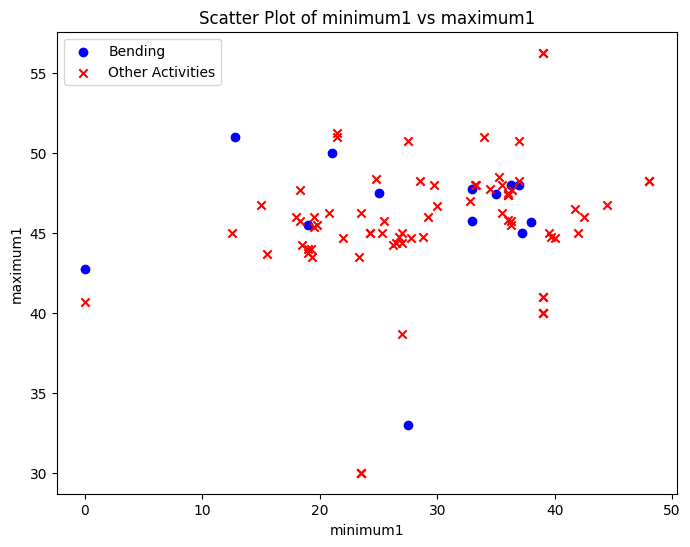

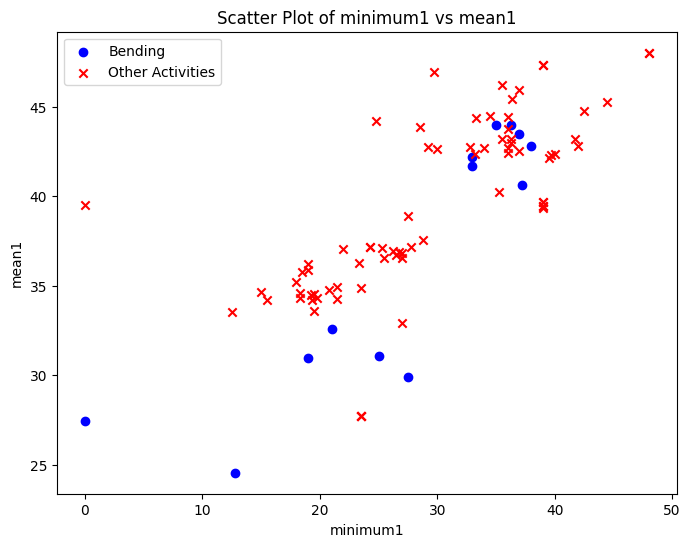

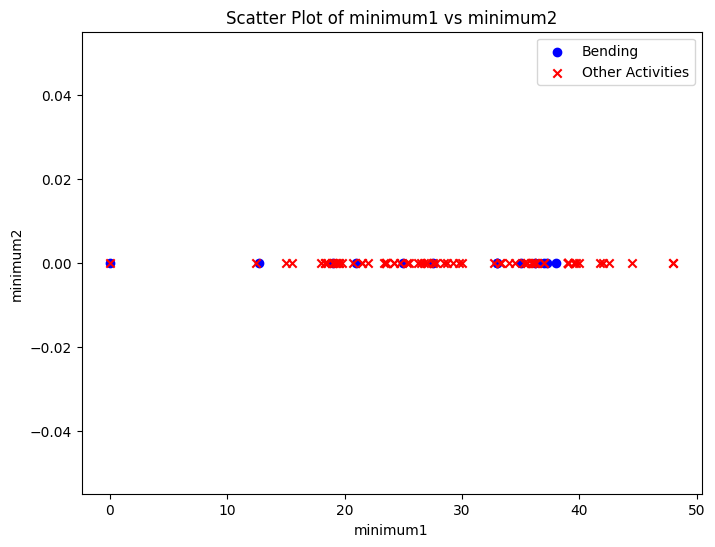

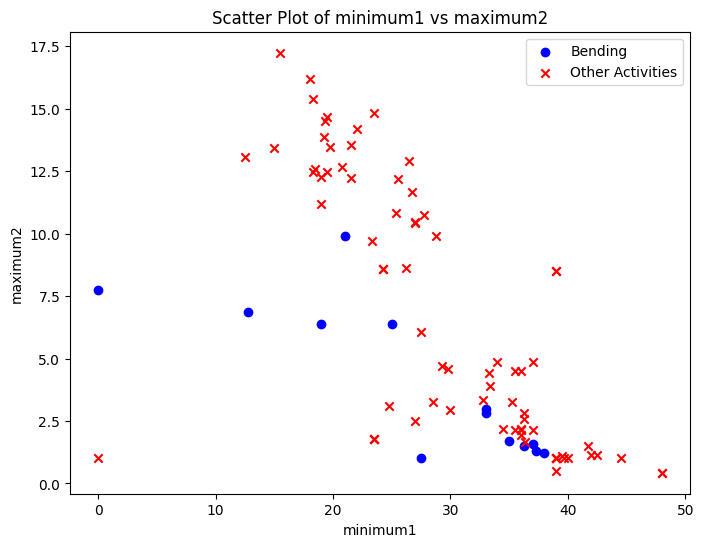

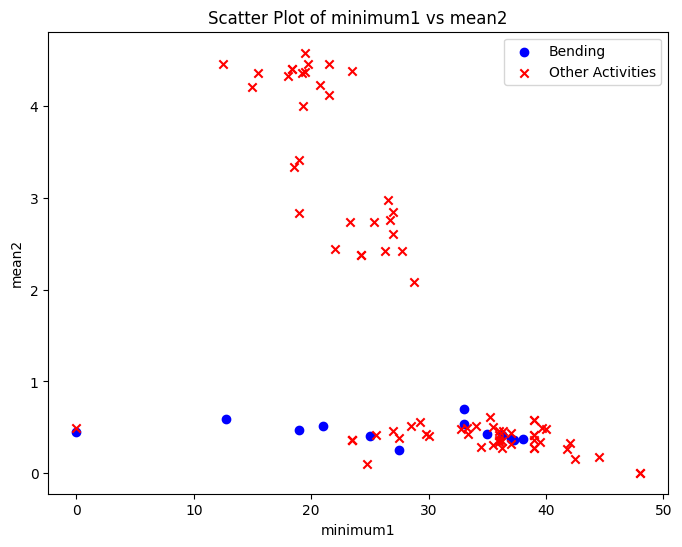

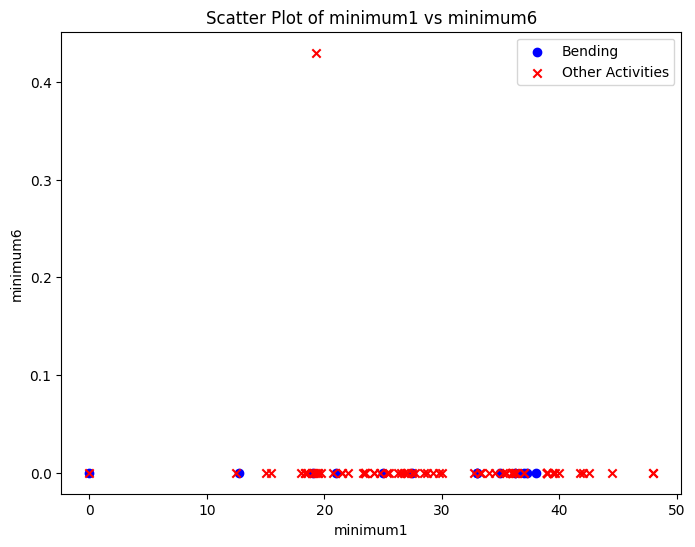

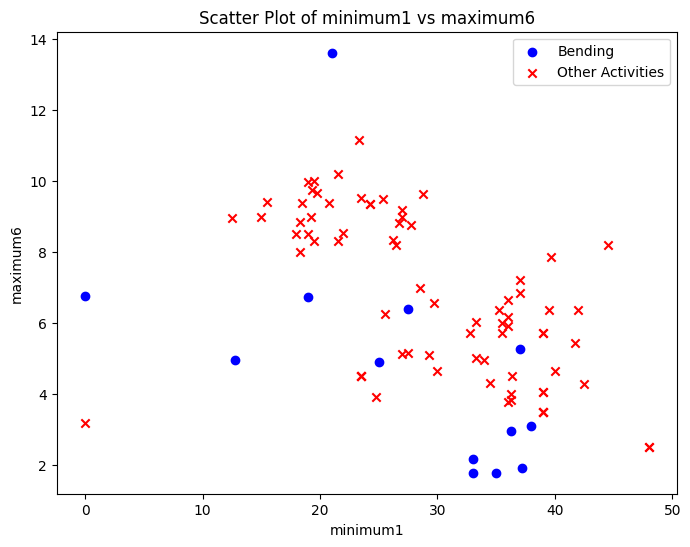

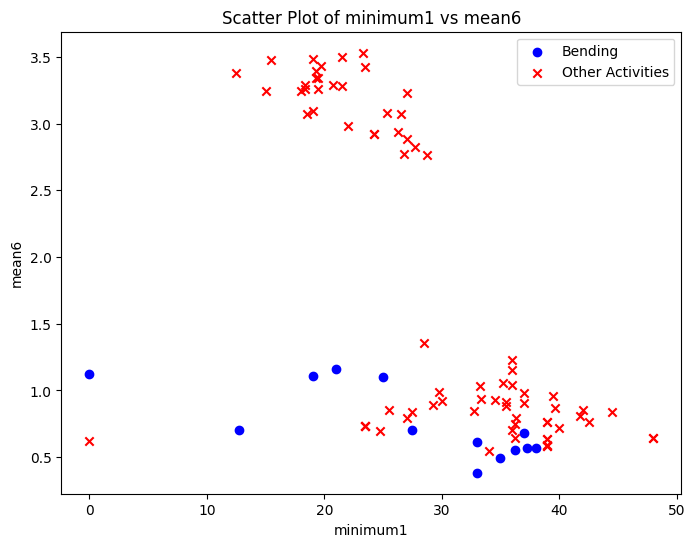

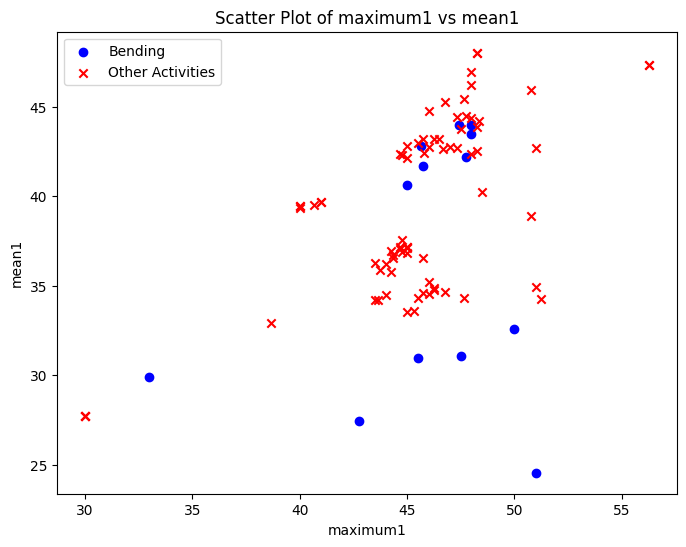

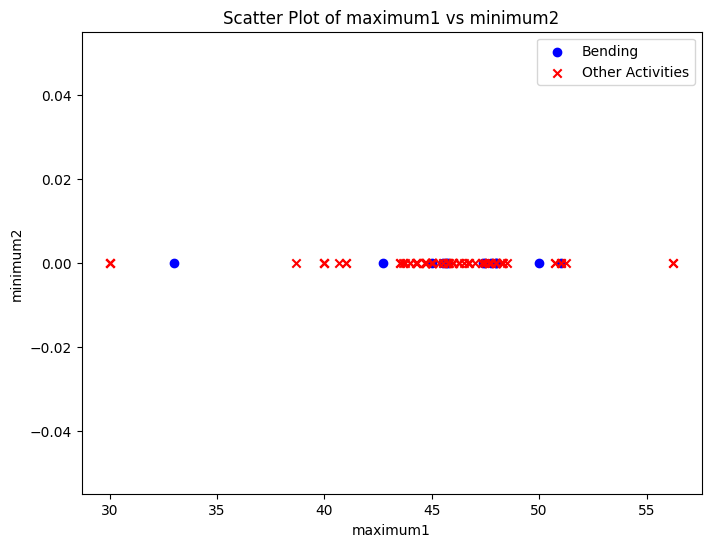

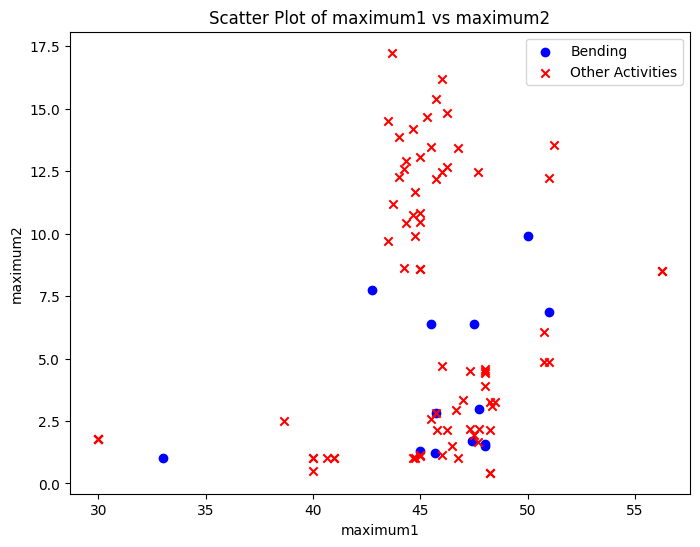

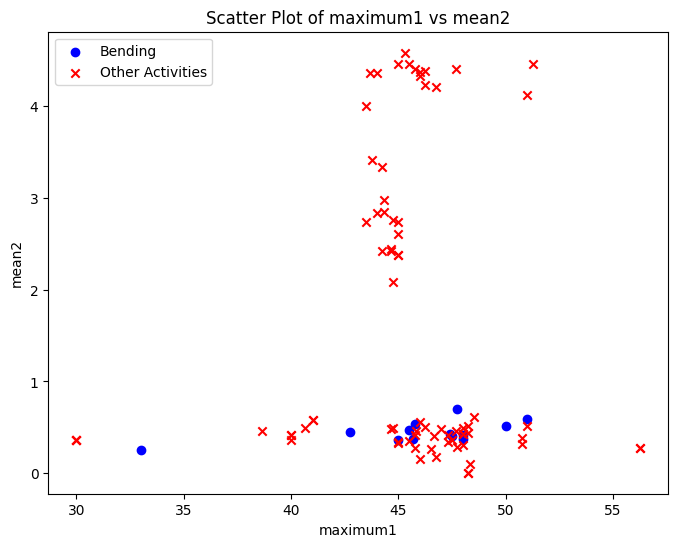

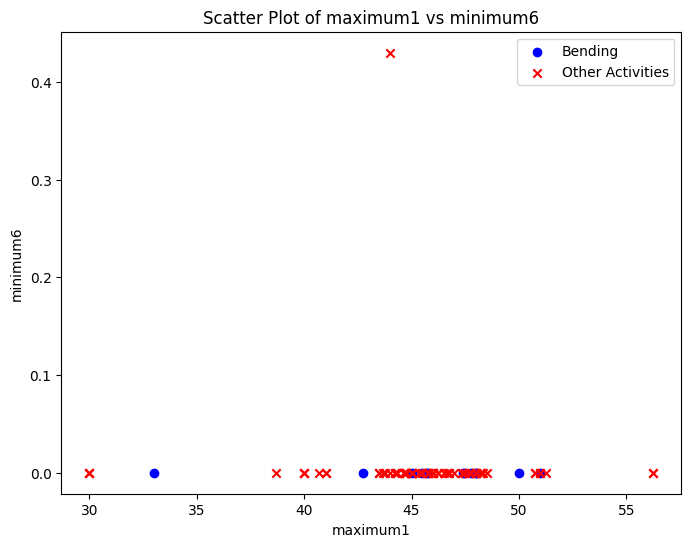

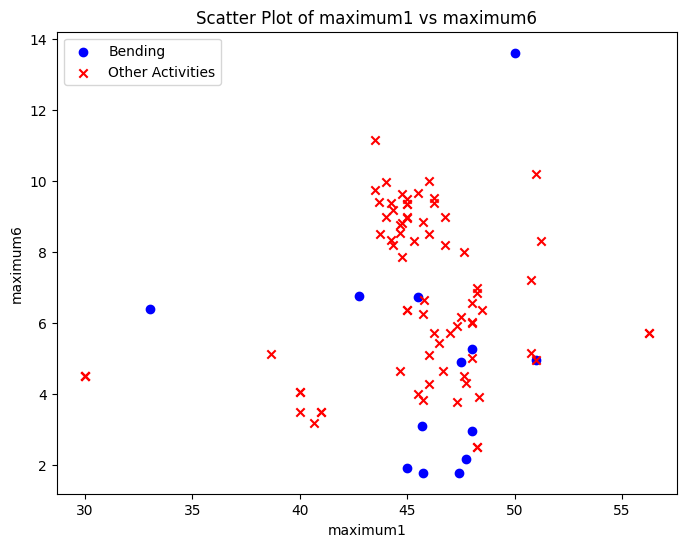

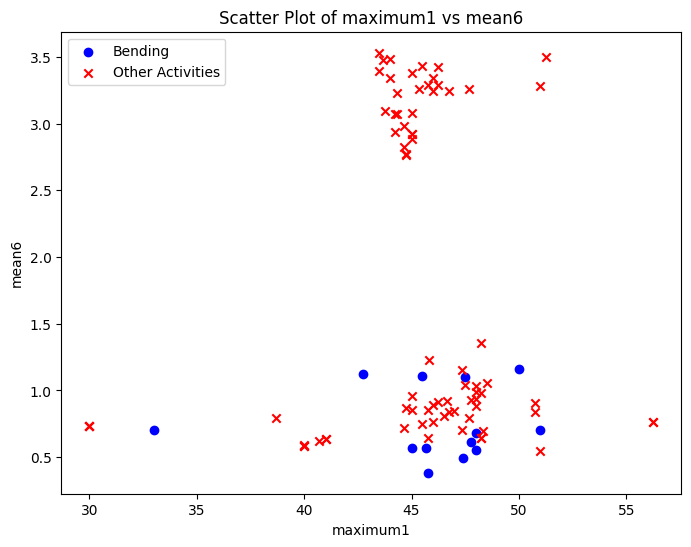

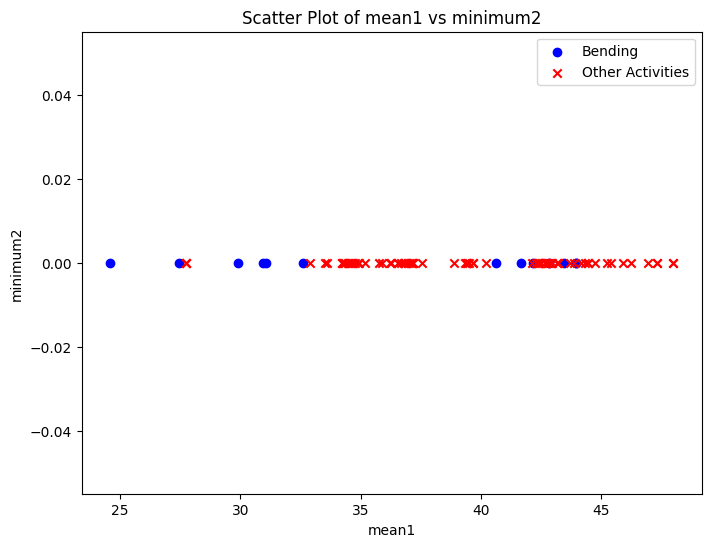

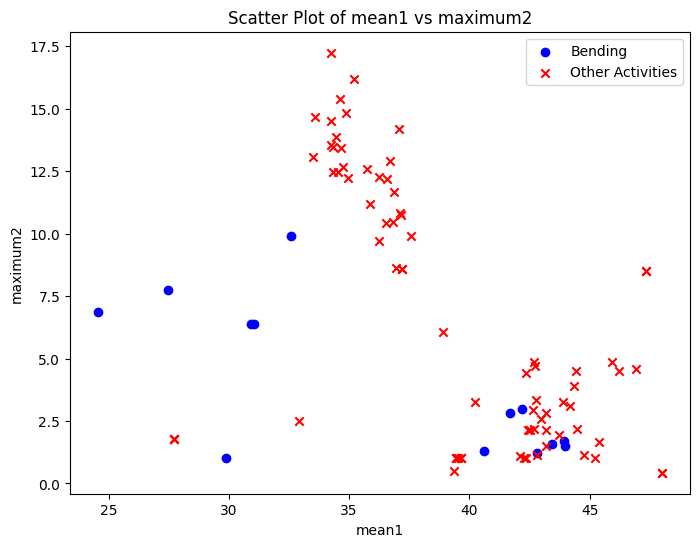

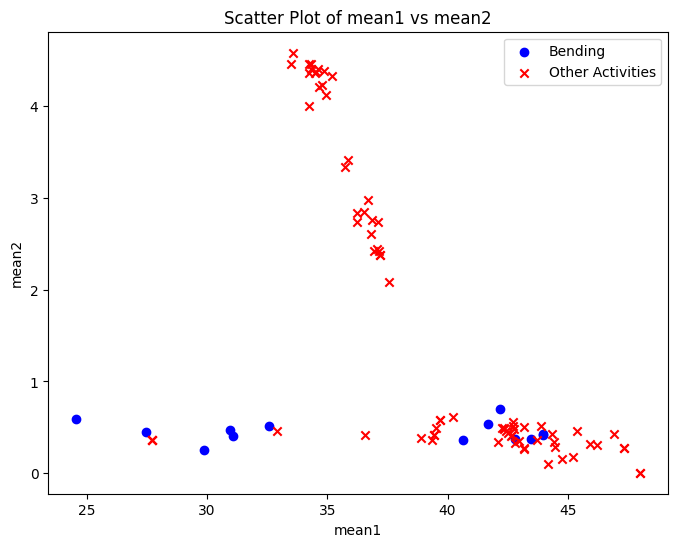

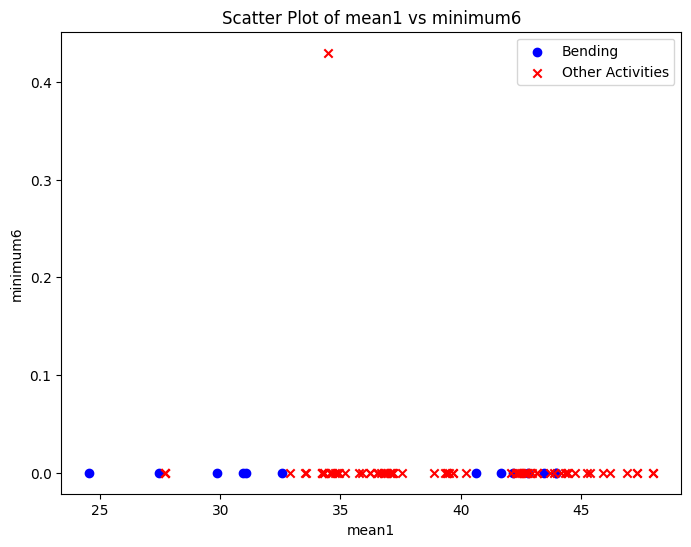

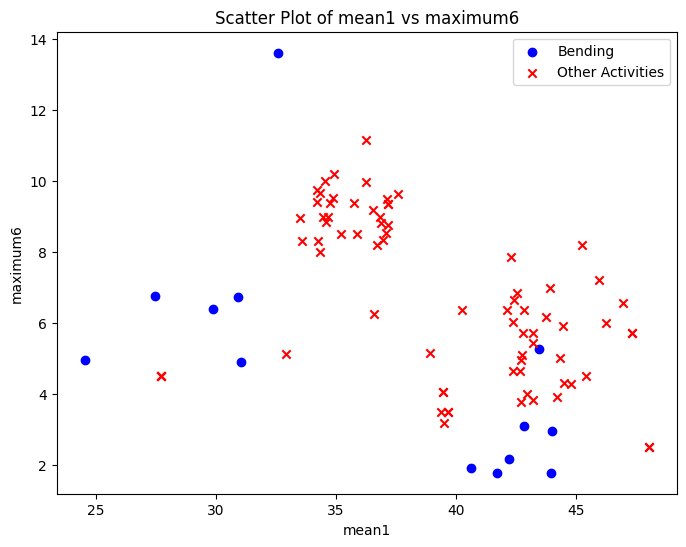

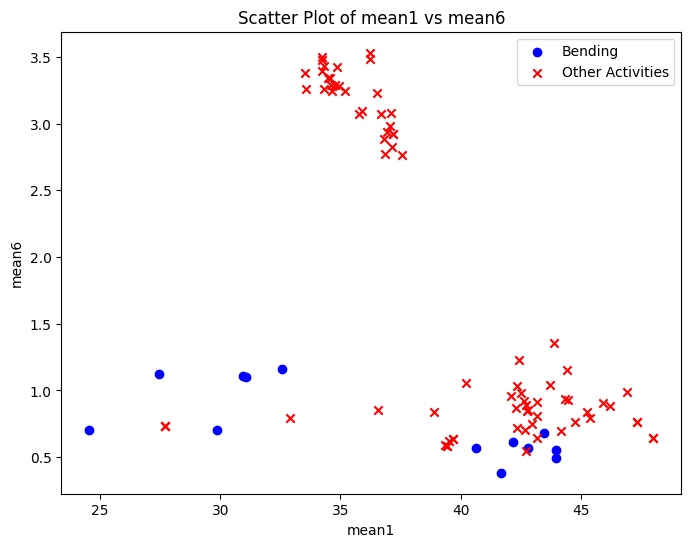

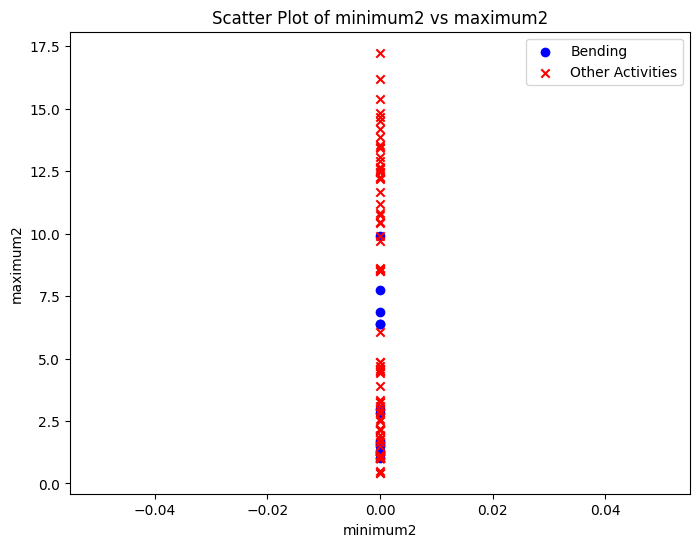

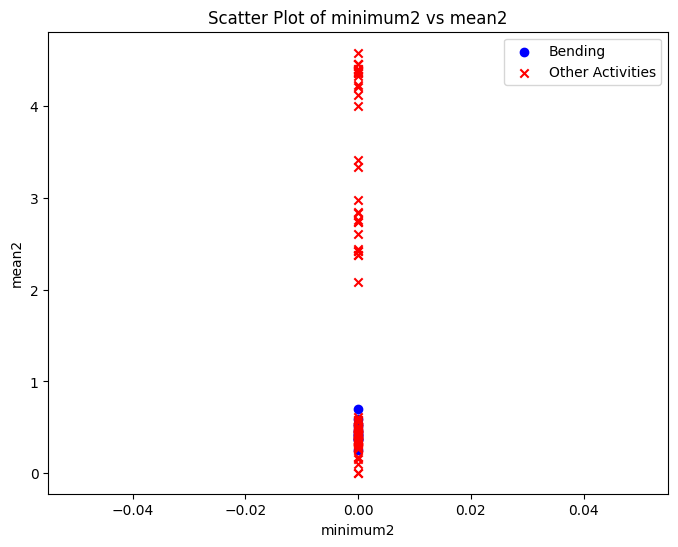

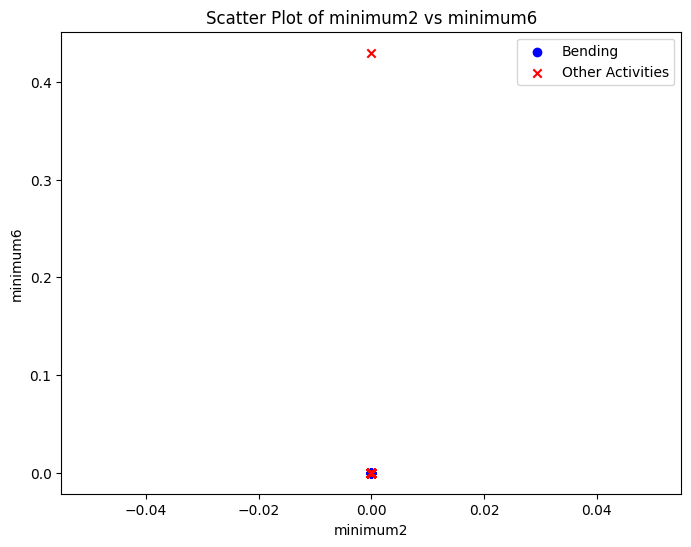

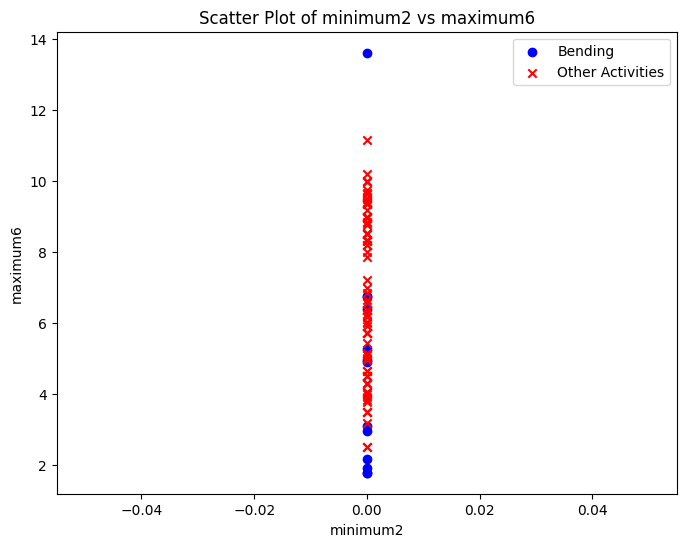

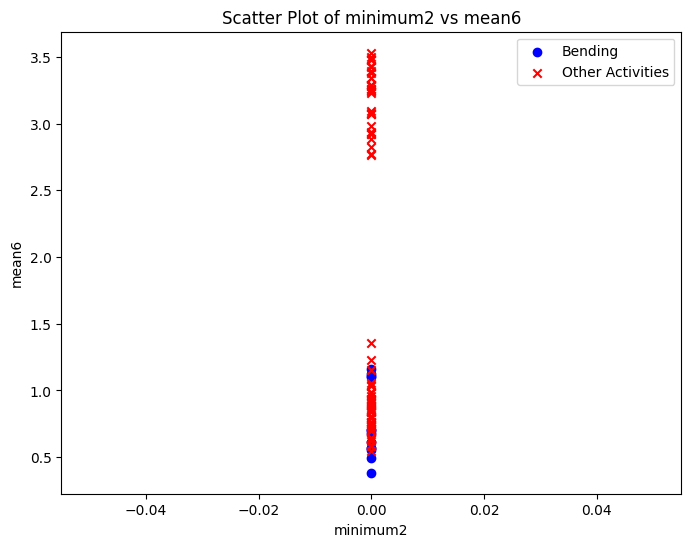

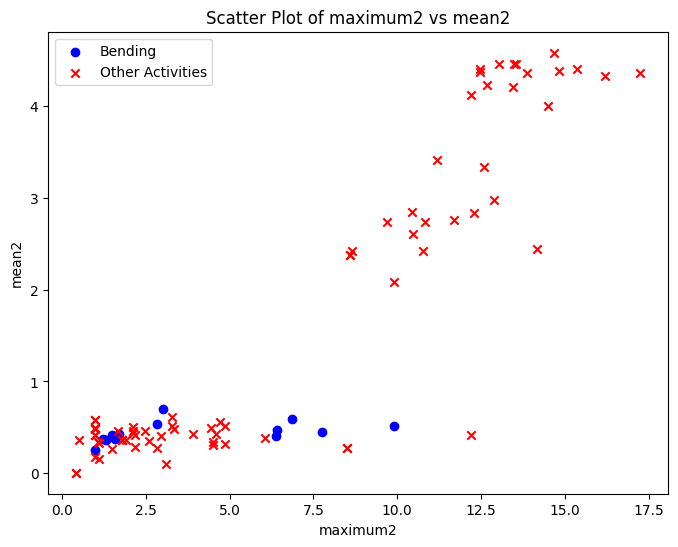

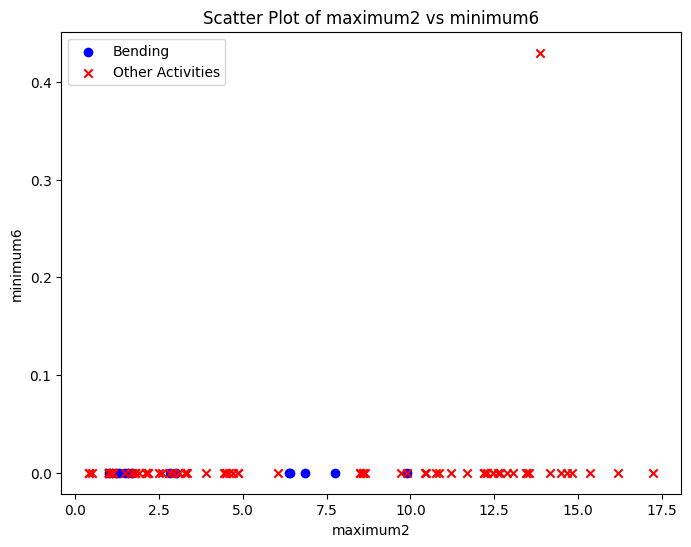

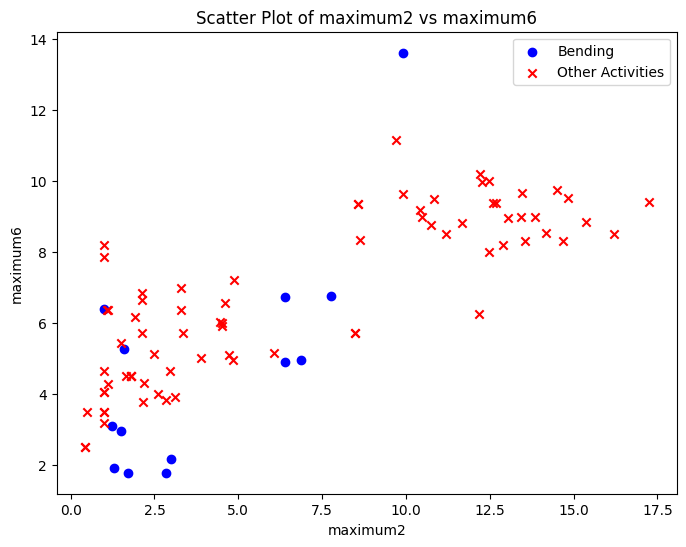

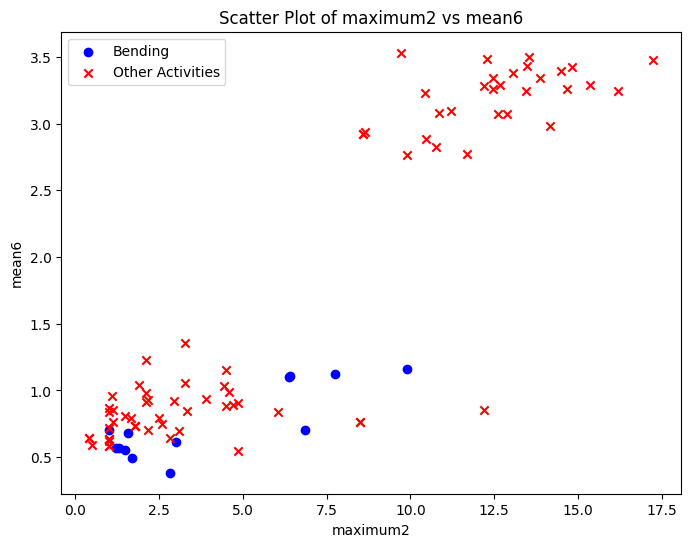

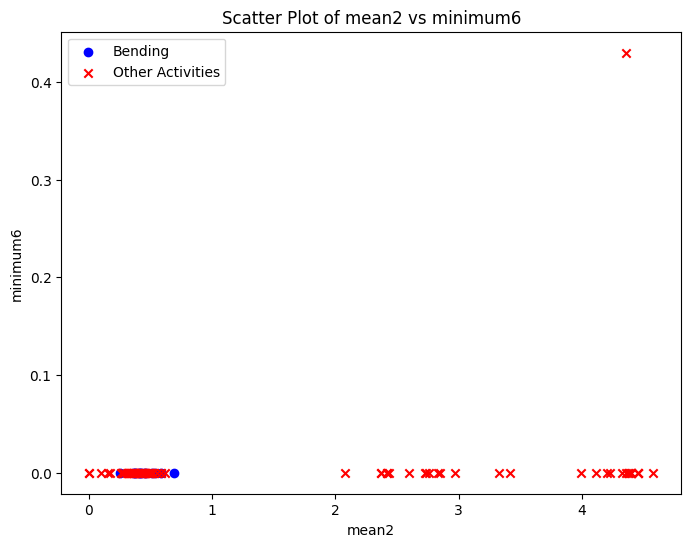

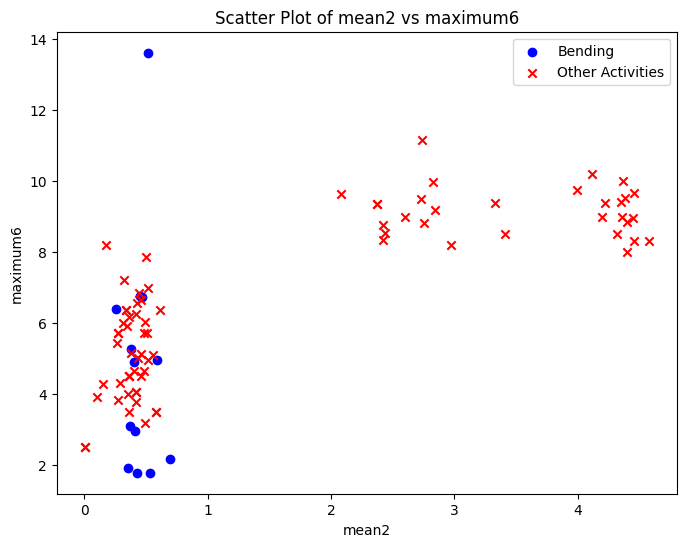

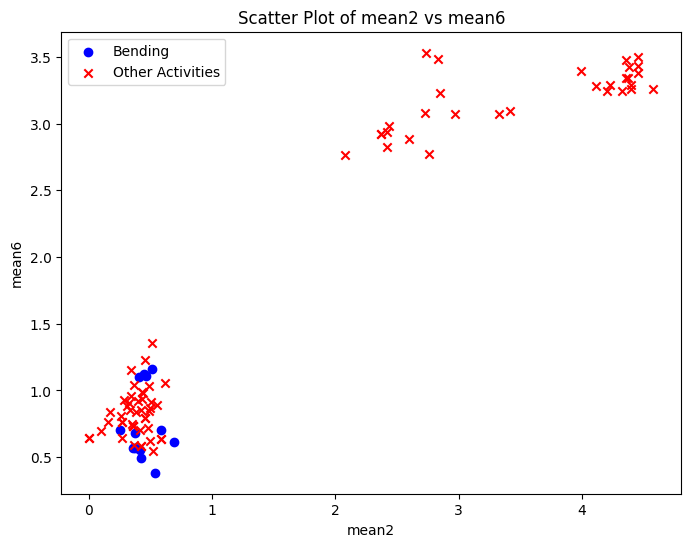

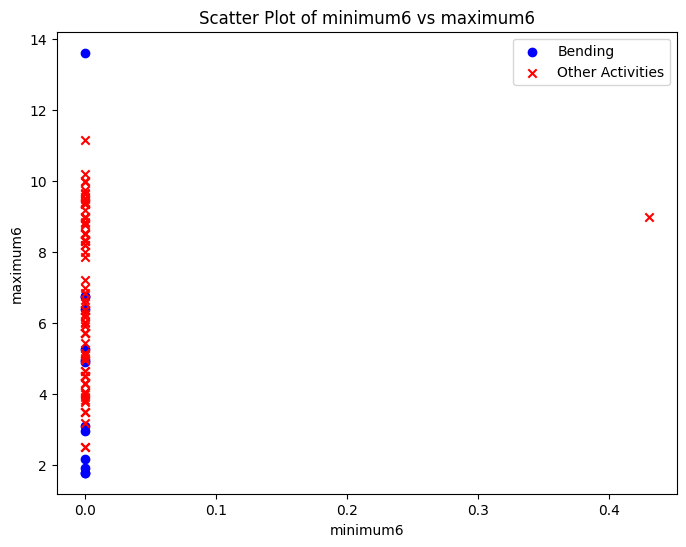

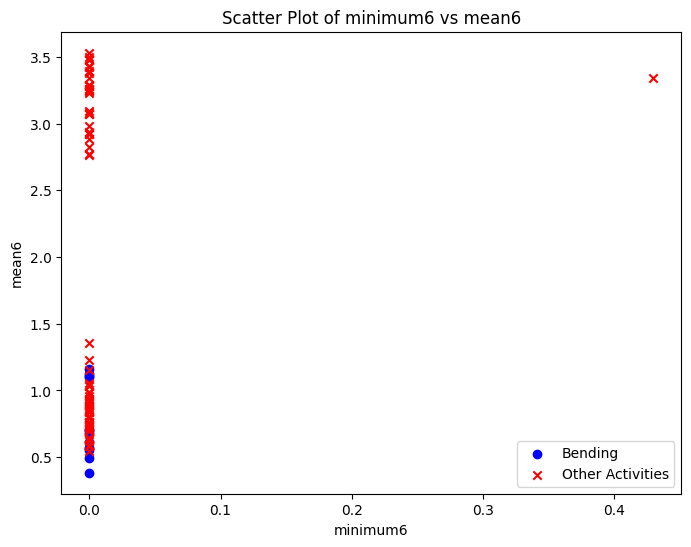

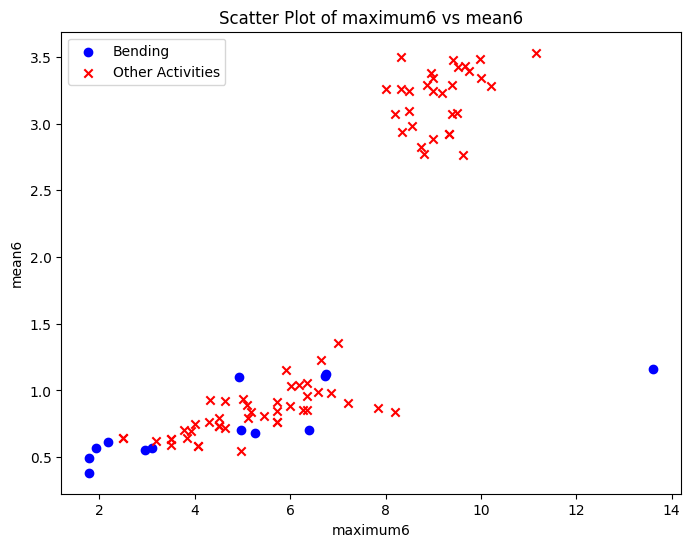

In [10]:
labels = []  # Create a list to store labels based on file paths

for data_path in all_path:
    if "bending" in data_path.lower():  
        labels.append(1)  
    else:
        labels.append(0)  

features_to_plot = ['minimum1', 'maximum1', 'mean1', 'minimum2', 'maximum2', 'mean2', 'minimum6', 'maximum6', 'mean6']
        
for i in range(len(features_to_plot)):
    for j in range(i + 1, len(features_to_plot)):
        feature1 = features_to_plot[i]
        feature2 = features_to_plot[j]

        plt.figure(figsize=(8, 6))
        plt.scatter(
            tm_features.loc[np.array(labels) == 1, feature1],  
            tm_features.loc[np.array(labels) == 1, feature2],
            label='Bending', color='blue', marker='o'
        )
        plt.scatter(
            tm_features.loc[np.array(labels) == 0, feature1],  
            tm_features.loc[np.array(labels) == 0, feature2],
            label='Other Activities', color='red', marker='x'
        )
        plt.xlabel(feature1)
        plt.ylabel(feature2)
        plt.legend()
        plt.title(f'Scatter Plot of {feature1} vs {feature2}')
        plt.show()

#### ii. Break each time series into two equal-length segments, resulting in 12 time series per instance, and repeat the scatter plot experiment.

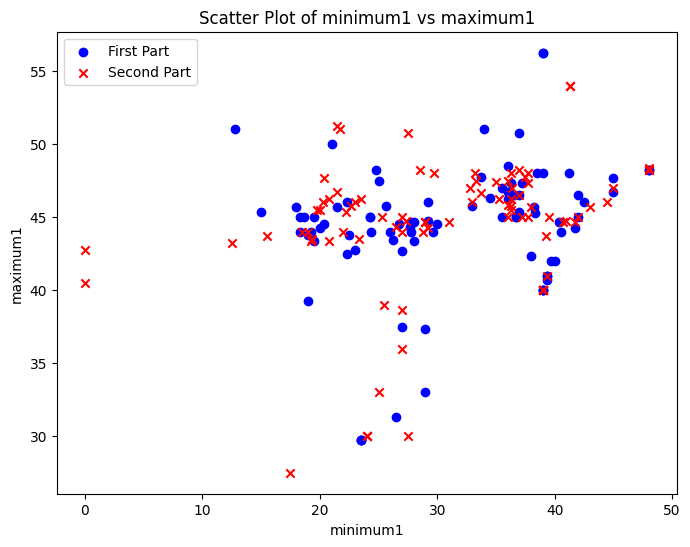

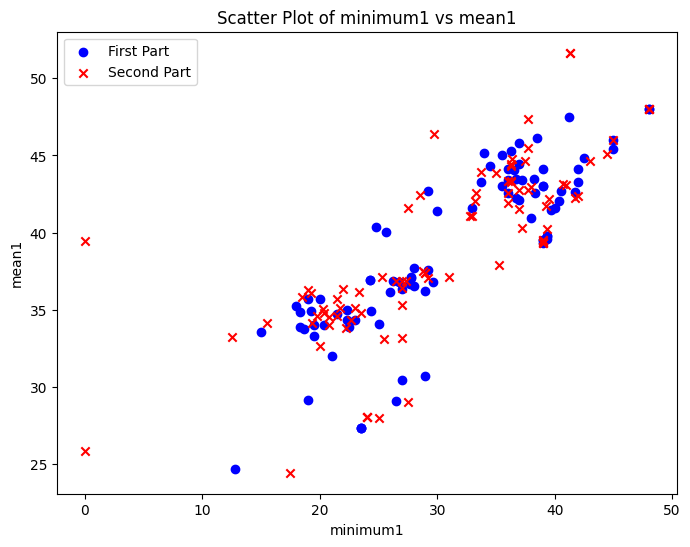

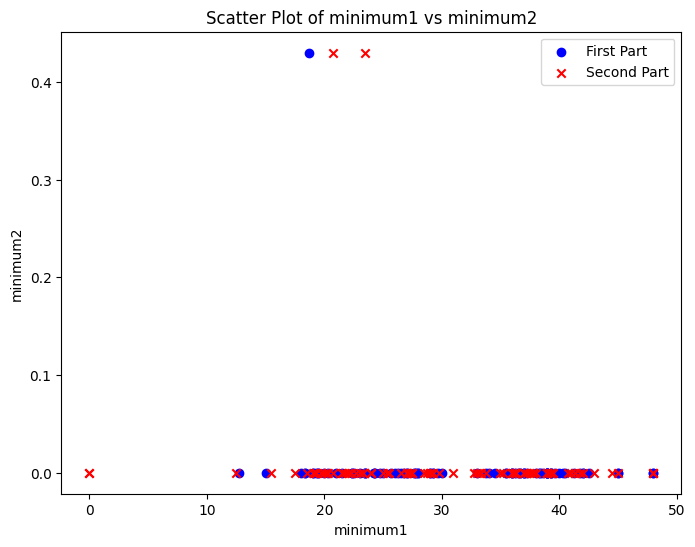

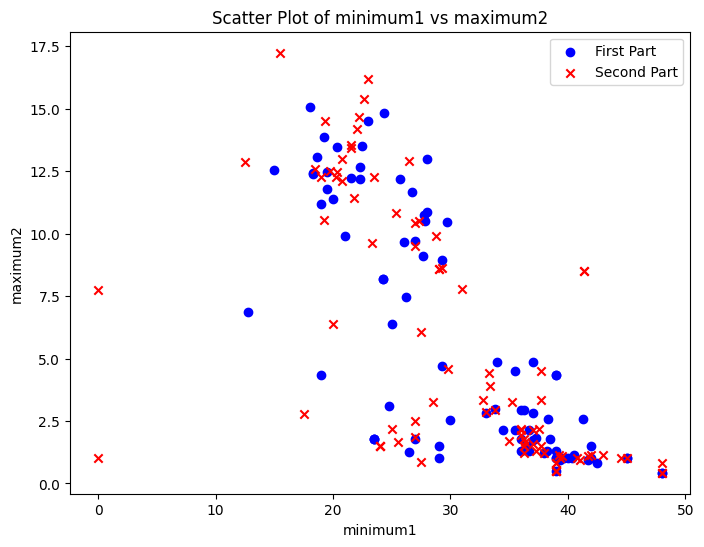

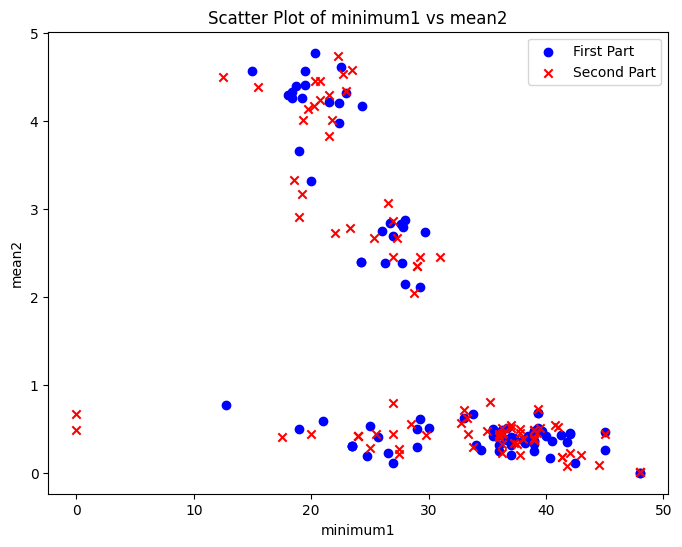

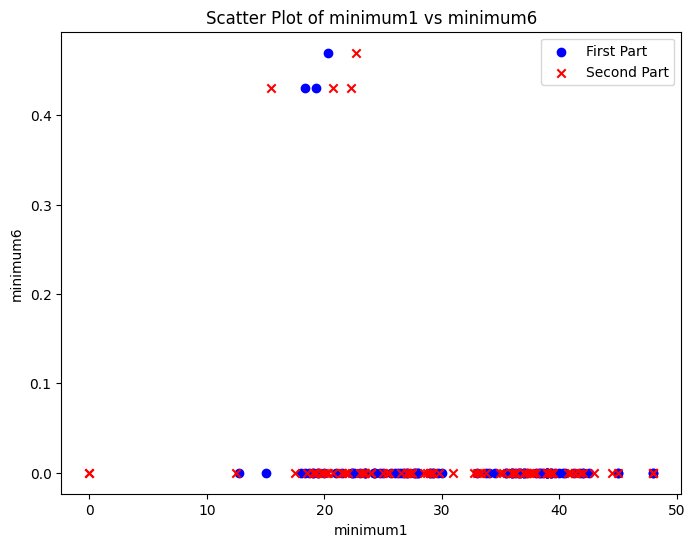

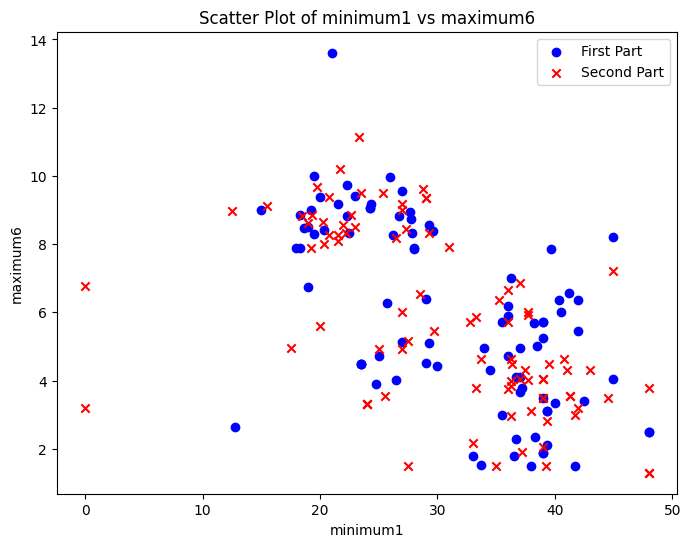

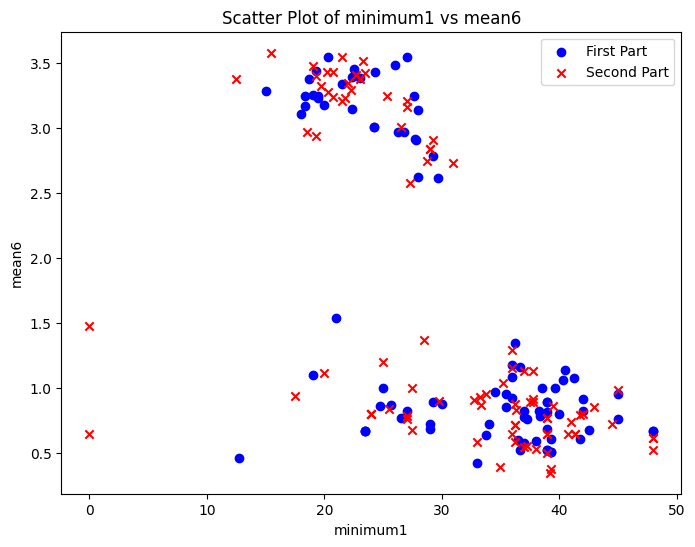

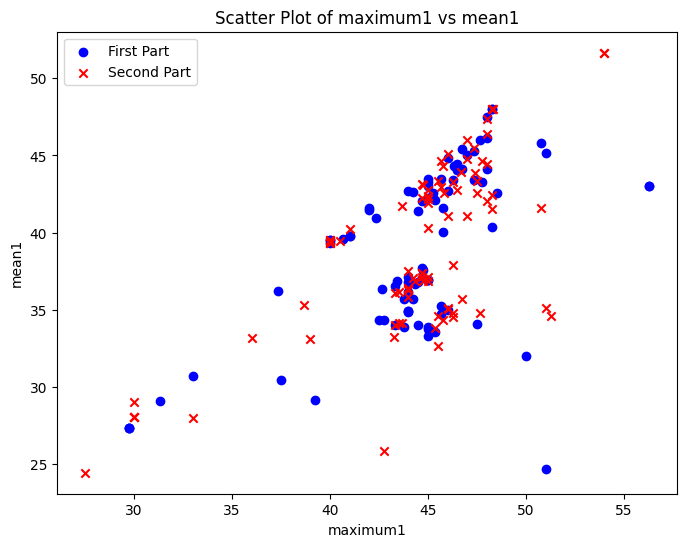

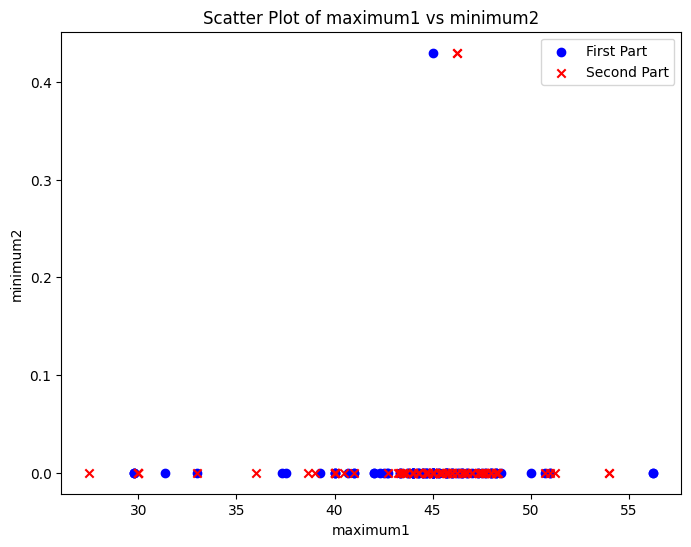

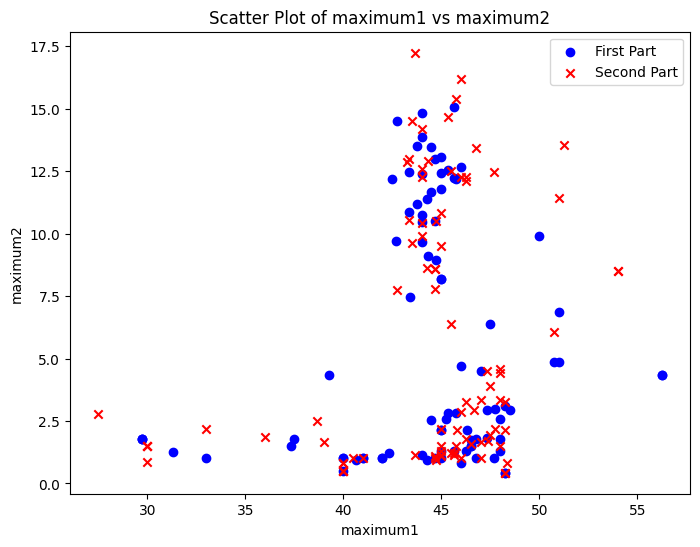

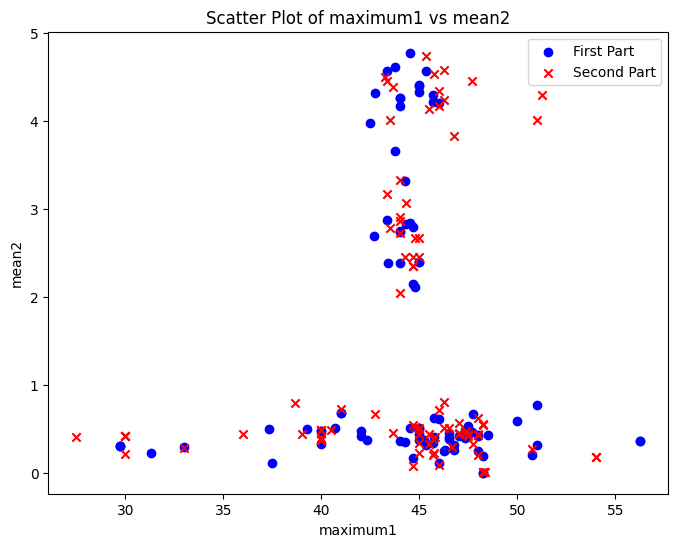

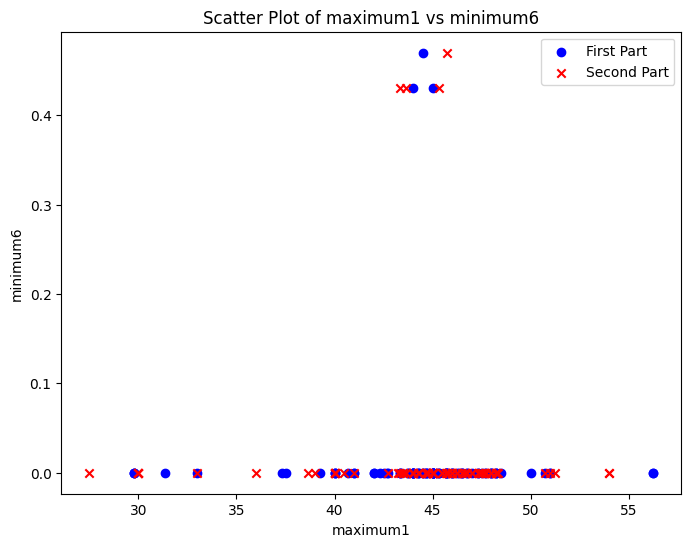

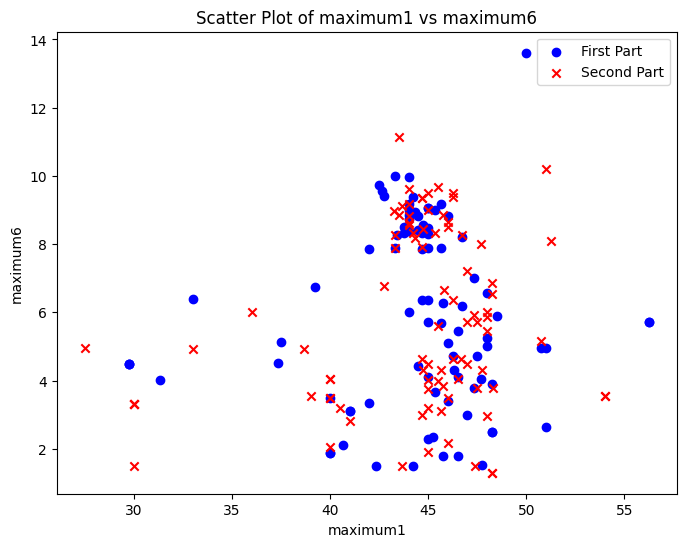

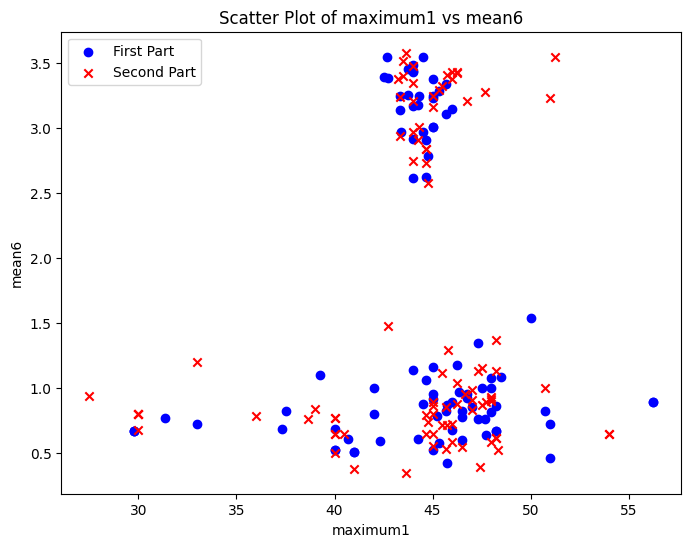

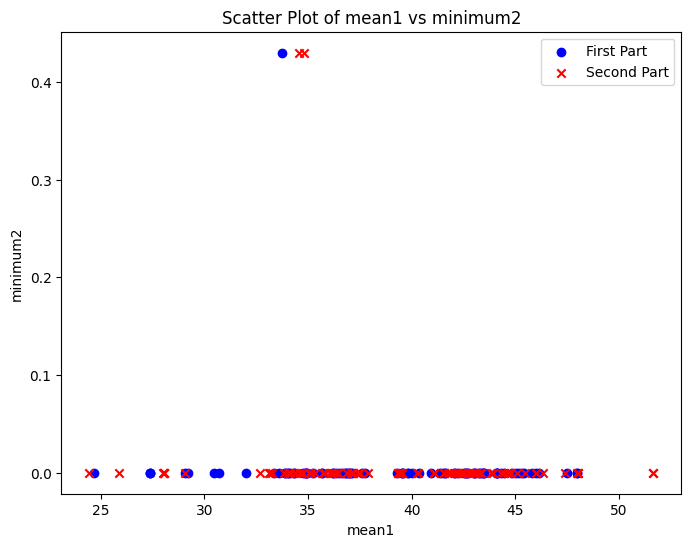

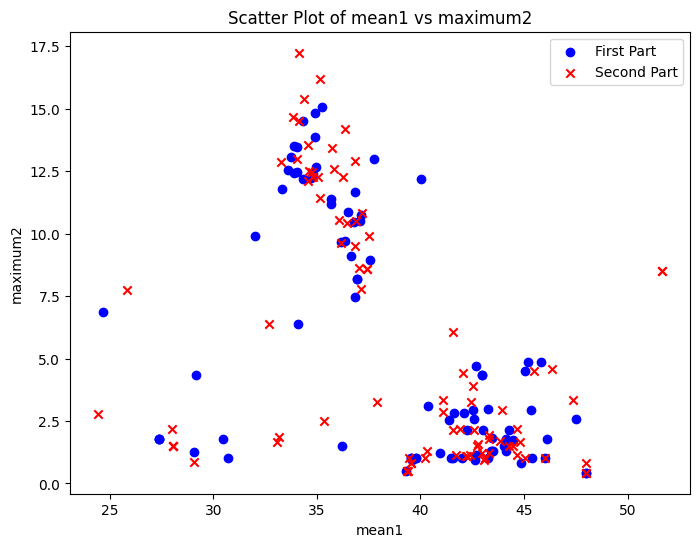

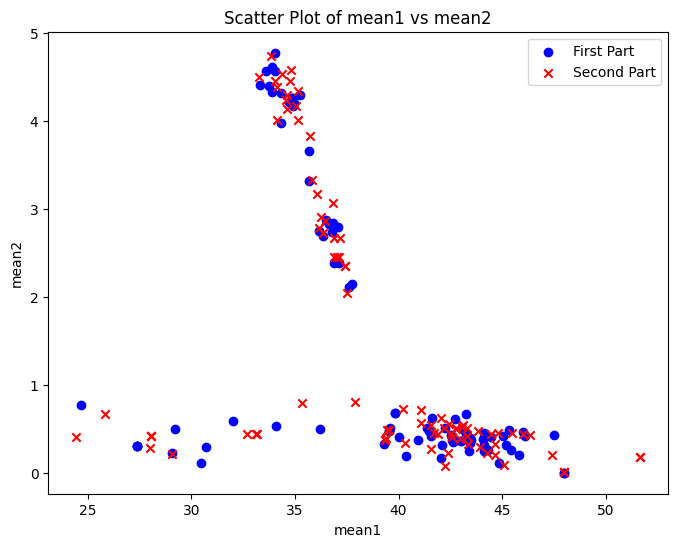

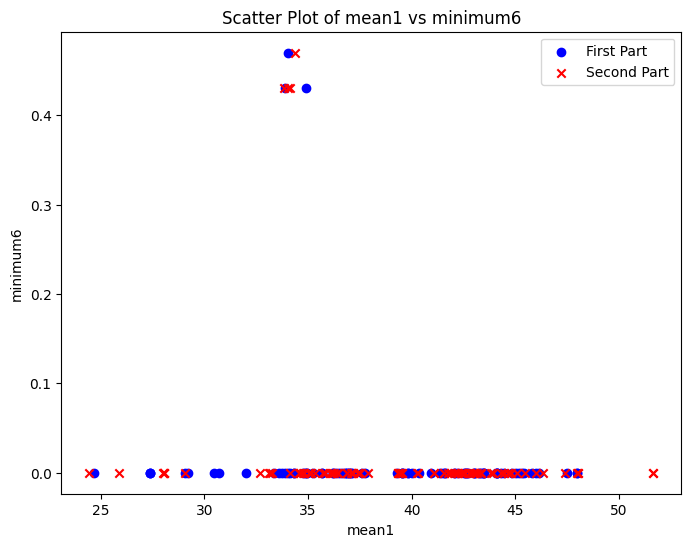

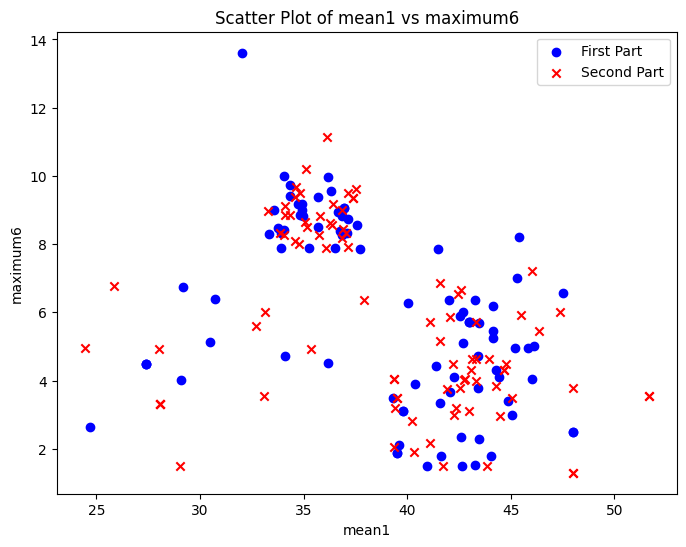

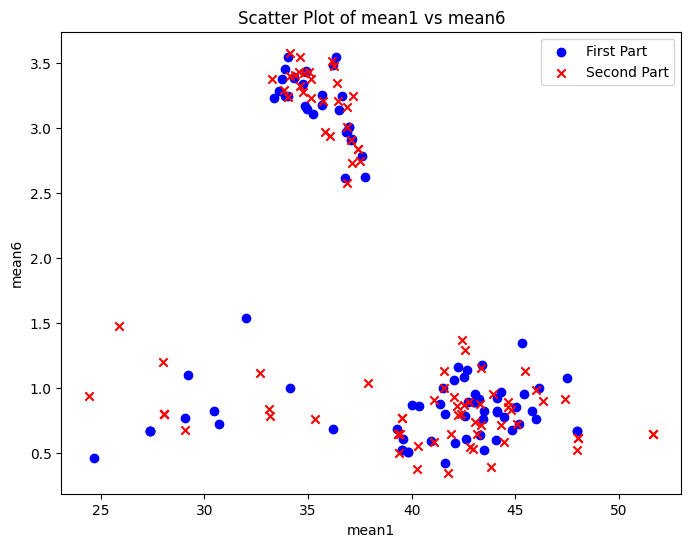

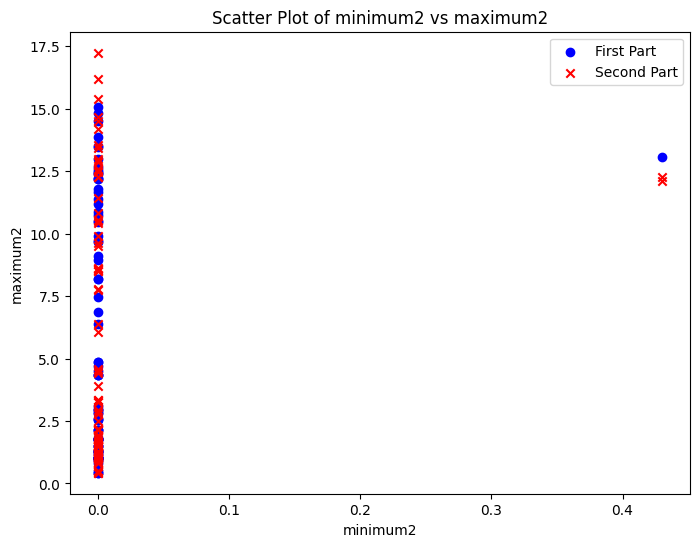

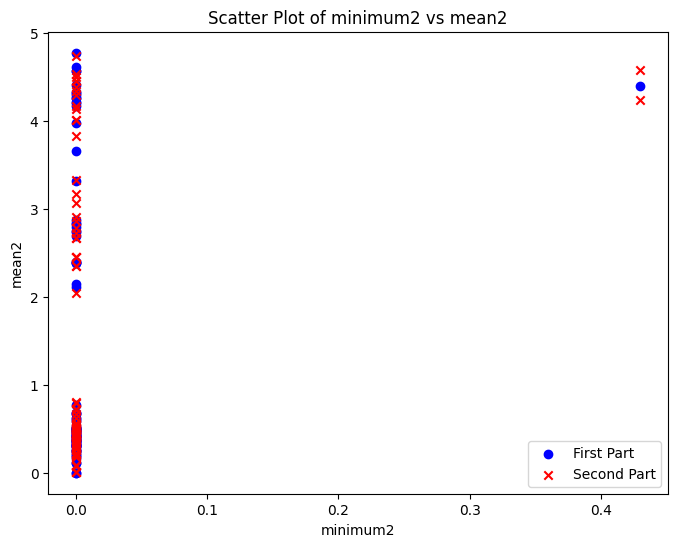

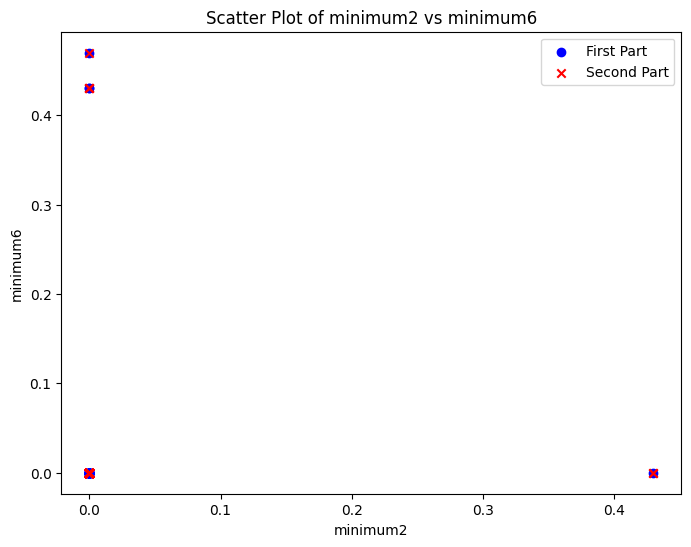

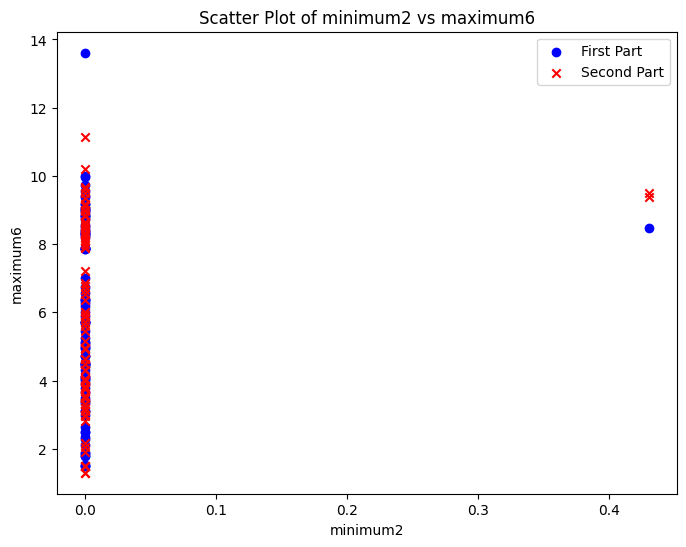

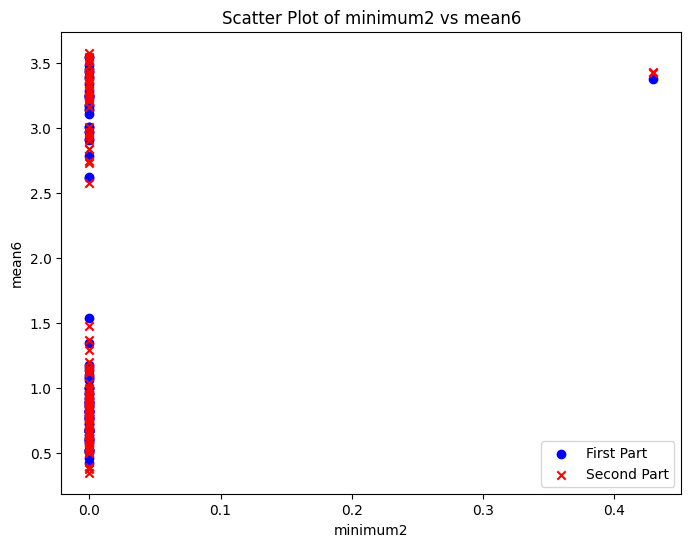

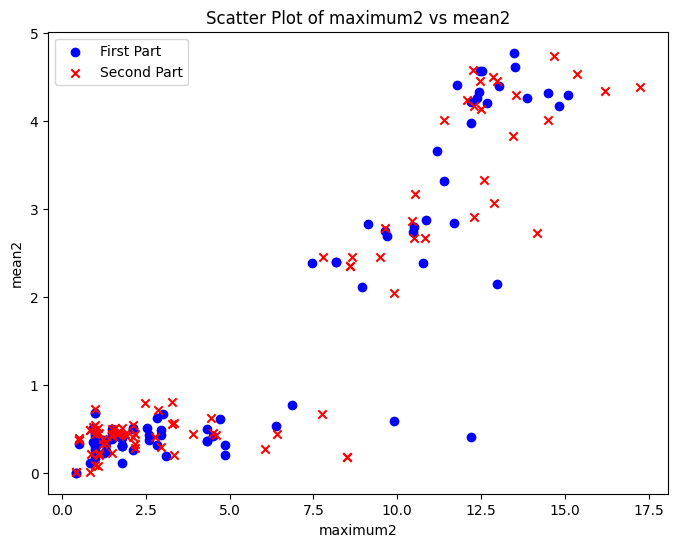

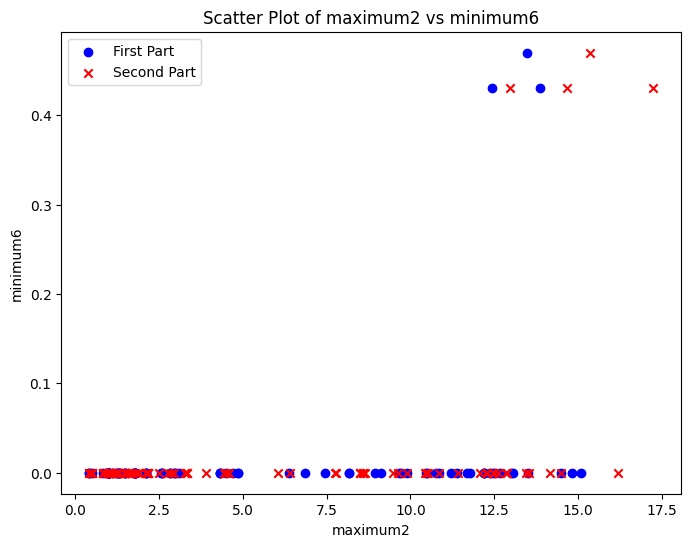

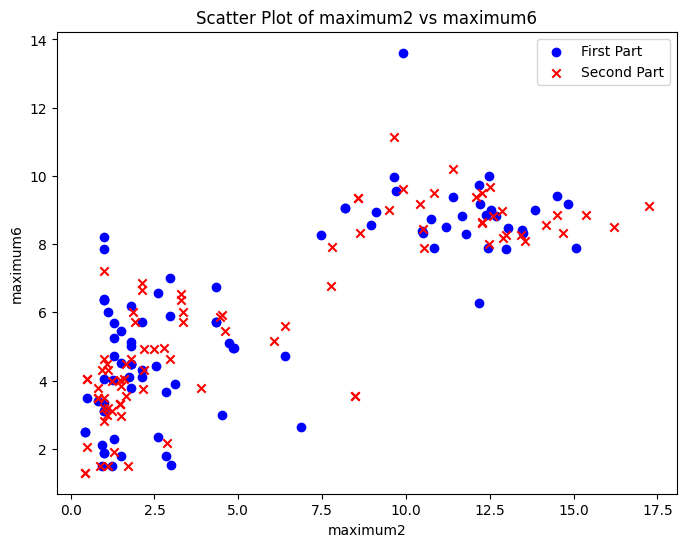

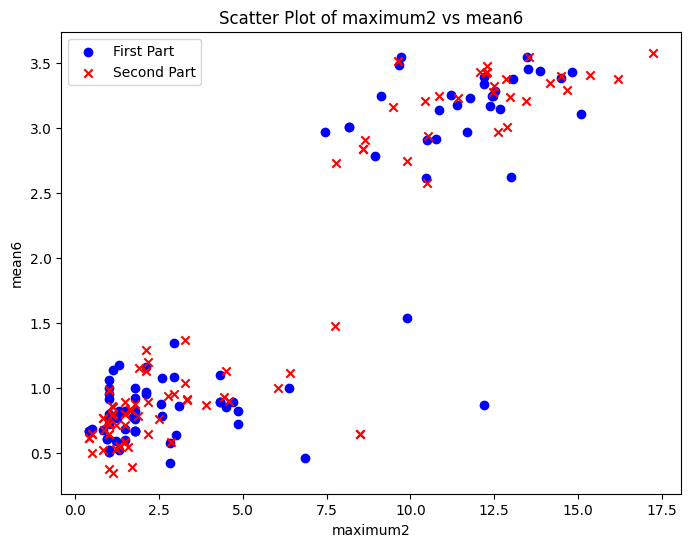

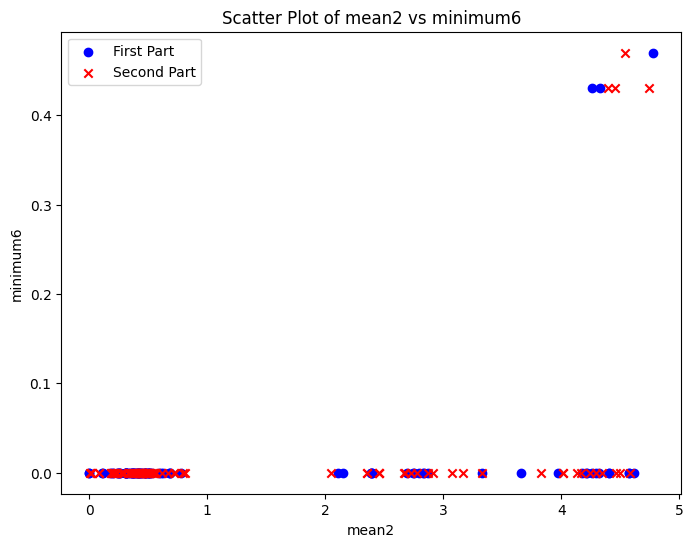

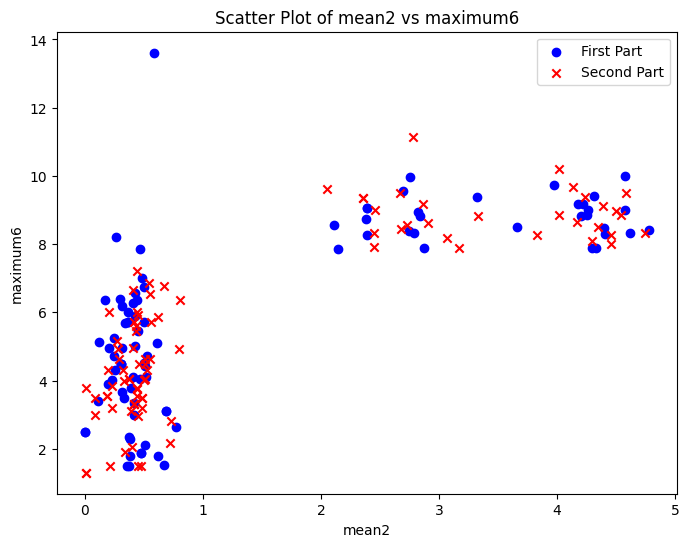

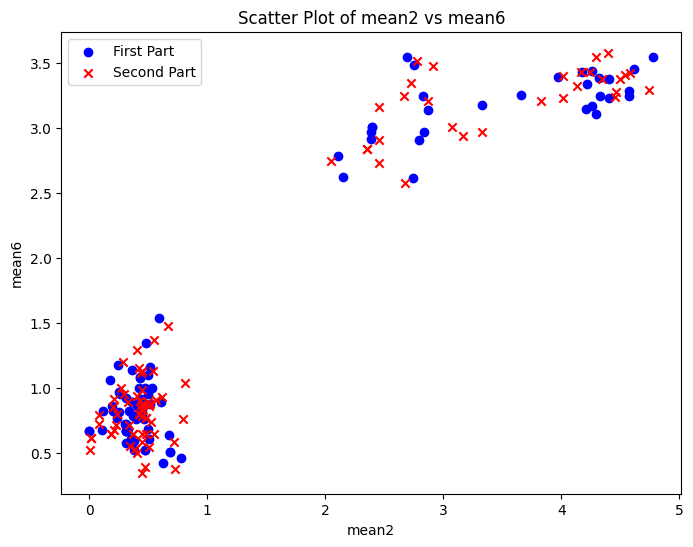

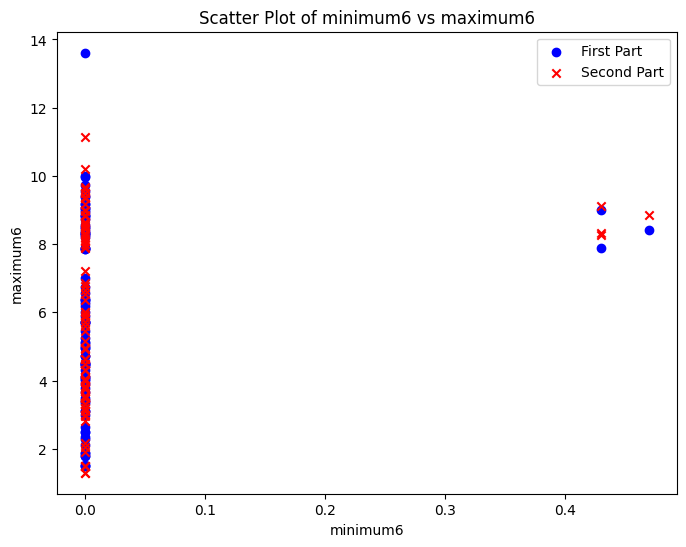

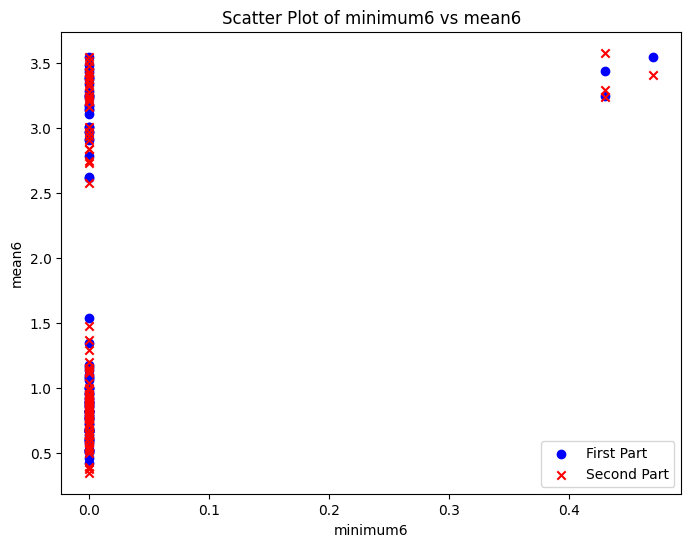

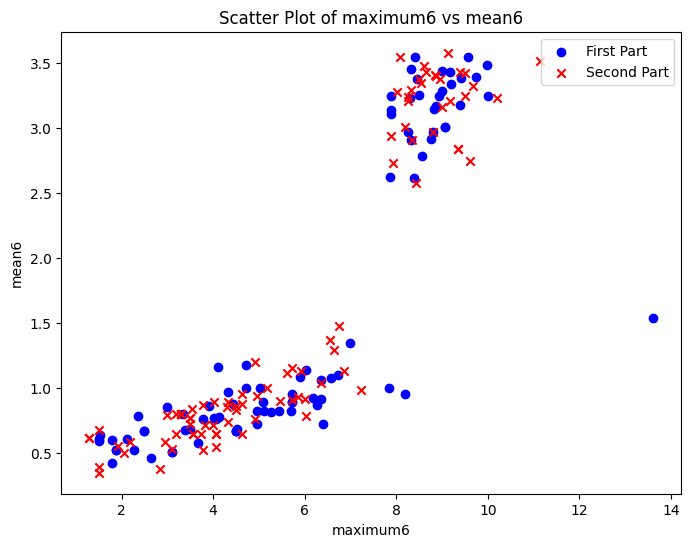

In [11]:
features_to_plot = ['minimum1', 'maximum1', 'mean1', 'minimum2', 'maximum2', 'mean2', 'minimum6', 'maximum6', 'mean6']

first_part_features = []
second_part_features = []

for data_path in all_path:
    df = pd.read_csv(data_path, skiprows=4)
    df = df.set_index(df.columns[0])
    
    split_point = len(df) // 2
    first_part_df = df.iloc[:split_point]
    second_part_df = df.iloc[split_point:]
    
    first_part_instance_data = []
    for column in first_part_df.columns:
        col_data_first = first_part_df[column]
        min_value_first = col_data_first.min()
        max_value_first = col_data_first.max()
        mean_value_first = col_data_first.mean()
        median_value_first = col_data_first.median()
        std_deviation_first = col_data_first.std()
        first_quartile_first = np.percentile(col_data_first, 25)
        third_quartile_first = np.percentile(col_data_first, 75)

        first_part_instance_data.extend([min_value_first, max_value_first, mean_value_first, median_value_first, std_deviation_first, first_quartile_first, third_quartile_first])

    second_part_instance_data = []
    for column in second_part_df.columns:
        col_data_second = second_part_df[column]
        min_value_second = col_data_second.min()
        max_value_second = col_data_second.max()
        mean_value_second = col_data_second.mean()
        median_value_second = col_data_second.median()
        std_deviation_second = col_data_second.std()
        first_quartile_second = np.percentile(col_data_second, 25)
        third_quartile_second = np.percentile(col_data_second, 75)

        second_part_instance_data.extend([min_value_second, max_value_second, mean_value_second, median_value_second, std_deviation_second, first_quartile_second, third_quartile_second])

    first_part_features.append(first_part_instance_data)
    second_part_features.append(second_part_instance_data)

first_part_features_df = pd.DataFrame(first_part_features, columns=column_names)
second_part_features_df = pd.DataFrame(second_part_features, columns=column_names)
for i in range(len(features_to_plot)):
    for j in range(i + 1, len(features_to_plot)):
        feature1 = features_to_plot[i]
        feature2 = features_to_plot[j]

        plt.figure(figsize=(8, 6))
        plt.scatter(
            first_part_features_df[feature1],  
            first_part_features_df[feature2],
            label='First Part', color='blue', marker='o'
        )
        plt.scatter(
            second_part_features_df[feature1],  
            second_part_features_df[feature2],
            label='Second Part', color='red', marker='x'
        )
        plt.xlabel(feature1)
        plt.ylabel(feature2)
        plt.legend()
        plt.title(f'Scatter Plot of {feature1} vs {feature2}')
        plt.show()

#### iii. Break each time series into varying segments (l ∈ {1, 2, ..., 20}), utilize logistic regression, and perform feature selection using 5-fold cross-validation. Address class imbalance with stratified cross-validation.

In [1]:
X = tm_features[features_to_plot]
y = np.array(labels)
def split_into_subsequences(X, l):
    subsequences = []
    for series in X:
        # Check if the length of the series is less than l
        if len(series) < l:
            subsequences.append(series)  # Keep the entire series if it's shorter than l
        else:
            # Split each time series into 'l' subsequences of equal length
            split_series = np.array_split(series[:l], l)
            subsequences.extend(split_series)
    return subsequences

def extract_features(subsequences):
    features = []
    for subsequence in subsequences:
        # Calculate time-domain features from each subsequence
        mean = np.mean(subsequence)
        std_dev = np.std(subsequence)
        min_value = np.min(subsequence)
        max_value = np.max(subsequence)
        # Add more features as needed
        features.append([mean, std_dev, min_value, max_value])
    return np.array(features)

best_accuracy = 0
best_l = None
best_p = None

for l in range(1, 21):

    subsequences = split_into_subsequences(X, l)
    features = extract_features(subsequences)
    print(f"Features shape for l={l}: {features.shape}")
    selector = SelectKBest(score_func=chi2, k='all')
    selector.fit(features, y)
    p_values = selector.pvalues_
    selected_features = features[:, p_values < 0.05]
    print(f"Selected Features shape for l={l}: {selected_features.shape}")
    model = LogisticRegression()
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []
    for train_idx, test_idx in skf.split(selected_features, y):
        X_train, X_test = selected_features[train_idx], selected_features[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.fit(X_train, y_train)
        accuracy = model.score(X_test, y_test)
        accuracies.append(accuracy)
    mean_accuracy = np.mean(accuracies)
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_l = l
        best_p = np.sum(p_values < 0.05) 
print(f"Best (l, p) pair: ({best_l}, {best_p})")
print(f"Best cross-validated accuracy: {best_accuracy:.2f}")

NameError: name 'tm_features' is not defined

#### iv. Report confusion matrix, ROC, AUC, logistic regression parameters (βi), and associated p-values on the training set.

Confusion Matrix (Training Data):
[[51  9]
 [ 0 10]]
ROC AUC (Training Data): 0.9633333333333334


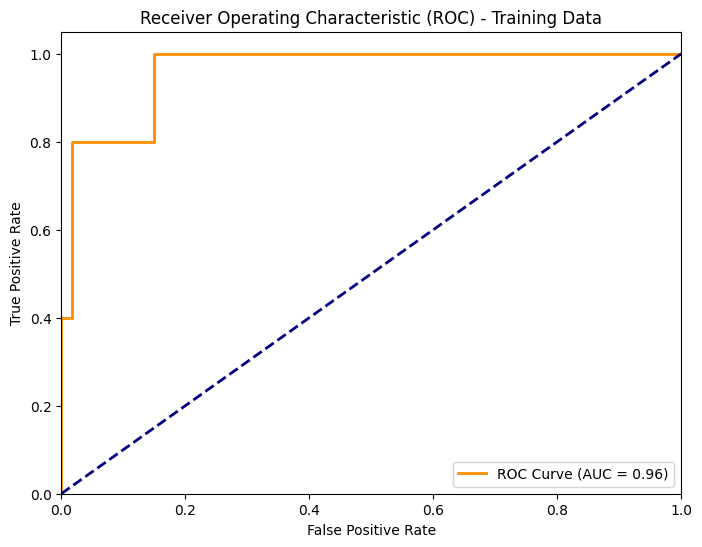

         Current function value: 0.095400
         Iterations: 35


LinAlgError: Singular matrix

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', class_weight='balanced')
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
print("Confusion Matrix (Training Data):")
print(conf_matrix_train)
y_probs_train = model.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_probs_train)
roc_auc_train = auc(fpr_train, tpr_train)
print(f"ROC AUC (Training Data): {roc_auc_train}")
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_train:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Training Data')
plt.legend(loc='lower right')
plt.show()
X_train_with_const = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_train_with_const)
result = logit_model.fit()
coefficients = result.params
p_values = result.pvalues
coefficients_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients, 'P-Value': p_values})
print("Logistic Regression Coefficients and P-Values:")
print(coefficients_df)

#### v. Test the classifier on the test set, maintaining consistent time series segmentation. Compare test set accuracy with cross-validation accuracy.

In [23]:
train_features = []
for data_path in train_data_paths:
    df = pd.read_csv(data_path, skiprows=4)
    df = df.set_index(df.columns[0])
    instance_data = []
    for column in df.columns:
        col_data = df[column]
        min_value = col_data.min()
        max_value = col_data.max()
        mean_value = col_data.mean()
        median_value = col_data.median()
        std_deviation = col_data.std()
        first_quartile = np.percentile(col_data, 25)
        third_quartile = np.percentile(col_data, 75)
        instance_data.extend([min_value, max_value, mean_value, median_value, std_deviation, first_quartile, third_quartile])
    train_features.append(instance_data)
train_features_df = pd.DataFrame(train_features, columns=column_names)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(train_features_df)
model = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', class_weight='balanced')
model.fit(X_train_std, y_train)
test_features = []
for data_path in test_data_paths:
    df = pd.read_csv(data_path, skiprows=4)
    df = df.set_index(df.columns[0])
    instance_data = []
    for column in df.columns:
        col_data = df[column]
        min_value = col_data.min()
        max_value = col_data.max()
        mean_value = col_data.mean()
        median_value = col_data.median()
        std_deviation = col_data.std()
        first_quartile = np.percentile(col_data, 25)
        third_quartile = np.percentile(col_data, 75)
        instance_data.extend([min_value, max_value, mean_value, median_value, std_deviation, first_quartile, third_quartile])
    test_features.append(instance_data)
test_features_df = pd.DataFrame(test_features, columns=column_names)
X_test_std = scaler.transform(test_features_df)
y_pred_test = model.predict(X_test_std)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Test Set Accuracy: {accuracy_test:.2%}")

ValueError: Found input variables with inconsistent numbers of samples: [69, 70]

#### vi. Assess the separation of classes for potential logistic regression parameter instability.

In [24]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

NameError: name 'y_pred_test' is not defined

### (b) Binary Classification Using L1-penalized logistic regression

#### i. L1-penalized Logistic Regression with Cross-validation:

In [30]:
X = tm_features[features_to_plot]
y = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (optional but recommended for logistic regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a logistic regression classifier with L1 penalty
lr = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

# Define a range of values for the regularization parameter C (the inverse of lambda)
param_grid = {'C': np.logspace(-3, 3, 7)}

# Perform grid search with cross-validation to find the best C value
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best hyperparameter values
best_C = grid_search.best_params_['C']

# Train the logistic regression model with the best C value
lr = LogisticRegression(penalty='l1', C=best_C, solver='liblinear', random_state=42)
lr.fit(X_train, y_train)

# Predict on the test set
y_pred = lr.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("ROC-AUC:", roc_auc)
print("\nClassification Report:\n", classification_rep)

Accuracy: 0.8888888888888888
ROC-AUC: 0.7999999999999999

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       0.67      0.67      0.67         3

    accuracy                           0.89        18
   macro avg       0.80      0.80      0.80        18
weighted avg       0.89      0.89      0.89        18



/Users/leyunlin/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/leyunlin/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### ii. Comparison of L1-penalized and p-value-based Variable Selection:

Accuracy of L1 is 0.8888888888888888, and ROC-AUC is 0.7999999999999999.

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments: Determine the best l for L1-penalized multinomial regression model. Report test error, confusion matrices, ROC, and AUC for multiclass classification.

In [31]:
# Standardize features (optional but recommended for logistic regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a multinomial logistic regression classifier with L1 penalty
lr = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=1000, random_state=42)

# Define a range of values for the regularization parameter C (the inverse of lambda)
param_grid = {'C': np.logspace(-3, 3, 7)}

# Perform grid search with cross-validation to find the best C value
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best hyperparameter values
best_C = grid_search.best_params_['C']

# Train the logistic regression model with the best C value
lr = LogisticRegression(penalty='l1', C=best_C, solver='saga', multi_class='multinomial', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Predict on the test set
y_pred = lr.predict(X_test)

# Calculate test error
test_error = 1 - lr.score(X_test, y_test)
print("Test Error:", test_error)


Test Error: 0.11111111111111116


/Users/leyunlin/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/leyunlin/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/leyunlin/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/leyunlin/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/leyunlin/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/leyunlin/anaconda3/lib/python3.10/site-pack

#### ii. Using Naïve Bayes classifiers with Gaussian and Multinomial priors.

In [36]:
unique_classes = np.unique(y)
num_classes = len(unique_classes)
confusion_matrices = []
for class_label in range(num_classes): 
    y_true_class = (y_test == class_label)
    y_pred_class = (y_pred == class_label)
    confusion_matrices.append(confusion_matrix(y_true_class, y_pred_class))
fpr = dict()
tpr = dict()
roc_auc = dict()
for class_label in range(num_classes):
    y_true_class = (y_test == class_label)
    y_pred_prob_class = lr.predict_proba(X_test)[:, class_label]
    fpr[class_label], tpr[class_label], _ = roc_curve(y_true_class, y_pred_prob_class)
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])